In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib

from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
from torch.autograd import Variable
from biotorch.module.biomodule import BioModule

from ANN import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                            std=(3*0.2023, 3*0.1994, 3*0.2010))])

cifar_dset_train = torchvision.datasets.CIFAR10('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR10('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = "cuda"
criterion = torch.nn.MSELoss().to(device)
# criterion = torch.nn.CrossEntropyLoss()
activation = F.relu
architecture = [int(32*32*3), 1000, 500, 10]
model = BioModule(MLP(architecture, activation = activation, final_layer_activation = None), mode = "fa").to(device)
model

Module has been converted to fa mode:

The layer configuration was:  {'type': 'fa', 'options': {'constrain_weights': False, 'gradient_clip': False, 'init': 'xavier'}}
- All the 3 <class 'torch.nn.modules.linear.Linear'> layers were converted successfully.


BioModule(
  (module): MLP(
    (linear_layers): ModuleList(
      (0): Linear(in_features=3072, out_features=1000, bias=True)
      (1): Linear(in_features=1000, out_features=500, bias=True)
      (2): Linear(in_features=500, out_features=10, bias=True)
    )
  )
)

In [5]:
model

BioModule(
  (module): MLP(
    (linear_layers): ModuleList(
      (0): Linear(in_features=3072, out_features=1000, bias=True)
      (1): Linear(in_features=1000, out_features=500, bias=True)
      (2): Linear(in_features=500, out_features=10, bias=True)
    )
  )
)

In [6]:
evaluateClassification(model, train_loader, "cuda")

Accuracy :	 0.10492


0.10492

In [7]:
# # specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001/2)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.001, nesterov=False)

lr_decay_step = 50
lr_decay = 0.9
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay)
trn_acc_list = []
tst_acc_list = []

n_epochs = 20
for epoch_ in range(n_epochs):
    model.train()
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = Variable(x.to(device)), Variable(y.to(device))
        y_one_hot = F.one_hot(y, num_classes=10)
        optimizer.zero_grad()
        y_hat = model(x)
#         loss = criterion(y_hat,y) # Use this if criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(y_hat,y_one_hot.to(torch.float32)) # Use this if criterion = torch.nn.MSELoss().to(device)
        # backward pass: compute gradient of the loss with respect to model parameters
#         model.zero_grad()
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
    
    scheduler.step()
    trn_acc = evaluateClassification(model, train_loader, device, False)
    tst_acc = evaluateClassification(model, test_loader, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

2500it [00:23, 105.50it/s]
15it [00:00, 144.10it/s]

Epoch : 1, Train Accuracy : 0.38992, Test Accuracy : 0.3896


2500it [00:21, 113.73it/s]
10it [00:00, 97.17it/s]

Epoch : 2, Train Accuracy : 0.43422, Test Accuracy : 0.4224


2500it [00:23, 104.24it/s]
10it [00:00, 99.19it/s]

Epoch : 3, Train Accuracy : 0.45956, Test Accuracy : 0.4428


2500it [00:24, 104.08it/s]
10it [00:00, 94.92it/s]

Epoch : 4, Train Accuracy : 0.47474, Test Accuracy : 0.4481


2500it [00:24, 103.80it/s]
10it [00:00, 96.05it/s]

Epoch : 5, Train Accuracy : 0.50952, Test Accuracy : 0.474


2500it [00:23, 104.69it/s]
10it [00:00, 99.04it/s]

Epoch : 6, Train Accuracy : 0.52318, Test Accuracy : 0.4809


2500it [00:23, 104.49it/s]
11it [00:00, 102.47it/s]

Epoch : 7, Train Accuracy : 0.53426, Test Accuracy : 0.4824


2500it [00:20, 121.03it/s]
22it [00:00, 212.43it/s]

Epoch : 8, Train Accuracy : 0.5576, Test Accuracy : 0.4931


2500it [00:11, 212.44it/s]
22it [00:00, 212.42it/s]

Epoch : 9, Train Accuracy : 0.56632, Test Accuracy : 0.4974


2500it [00:11, 210.53it/s]
22it [00:00, 211.92it/s]

Epoch : 10, Train Accuracy : 0.58674, Test Accuracy : 0.5056


2500it [00:12, 199.90it/s]
11it [00:00, 101.51it/s]

Epoch : 11, Train Accuracy : 0.59106, Test Accuracy : 0.4986


2500it [00:24, 102.34it/s]
11it [00:00, 103.00it/s]

Epoch : 12, Train Accuracy : 0.60868, Test Accuracy : 0.5037


2500it [00:24, 102.29it/s]
11it [00:00, 106.96it/s]

Epoch : 13, Train Accuracy : 0.6198, Test Accuracy : 0.5046


2500it [00:23, 104.61it/s]
10it [00:00, 99.24it/s]

Epoch : 14, Train Accuracy : 0.64662, Test Accuracy : 0.515


2500it [00:23, 105.09it/s]
11it [00:00, 108.32it/s]

Epoch : 15, Train Accuracy : 0.64708, Test Accuracy : 0.5135


2500it [00:23, 104.84it/s]
11it [00:00, 106.69it/s]

Epoch : 16, Train Accuracy : 0.67456, Test Accuracy : 0.5273


2500it [00:27, 92.08it/s] 
11it [00:00, 107.11it/s]

Epoch : 17, Train Accuracy : 0.68042, Test Accuracy : 0.5122


2500it [00:23, 105.56it/s]
11it [00:00, 106.01it/s]

Epoch : 18, Train Accuracy : 0.67904, Test Accuracy : 0.5182


2500it [00:23, 105.95it/s]
11it [00:00, 94.32it/s]

Epoch : 19, Train Accuracy : 0.71044, Test Accuracy : 0.527


2500it [00:21, 116.46it/s]


Epoch : 20, Train Accuracy : 0.71348, Test Accuracy : 0.5257


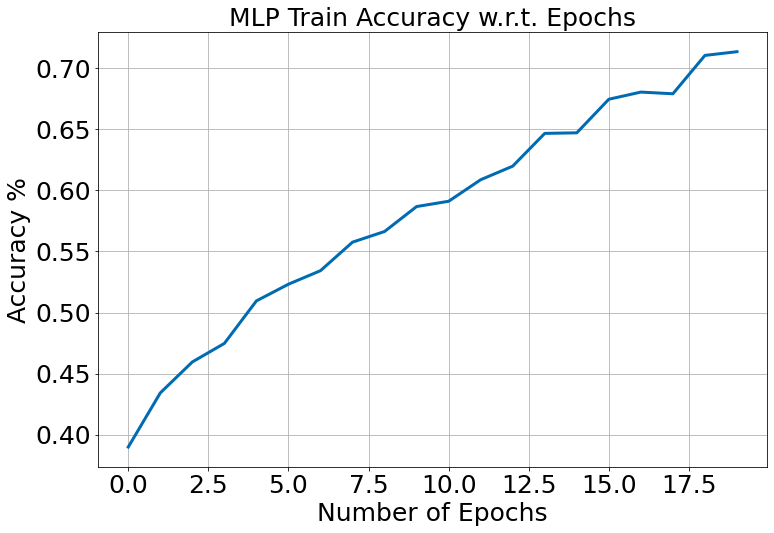

In [8]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'MLP Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

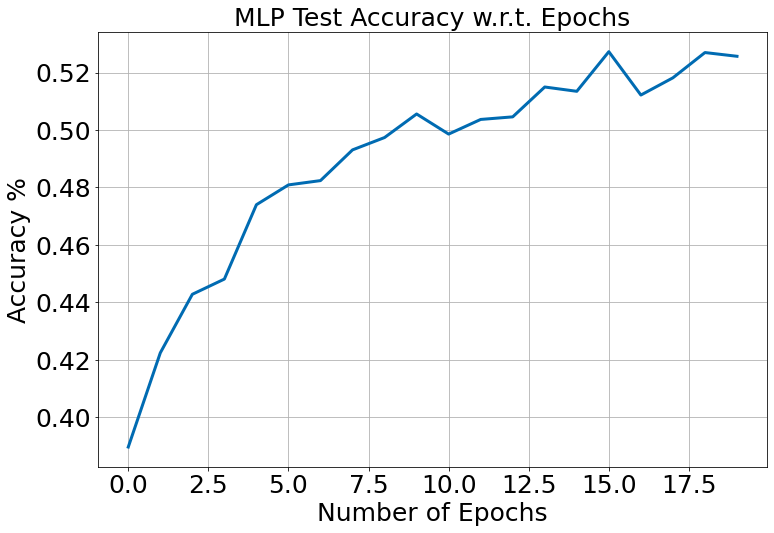

In [9]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'MLP Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [10]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 5e-05
    lr: 5e-05
    maximize: False
    weight_decay: 0
)